# Latent HGF: BA Project

Setup: Import packages/modules, disable Jax

In [1]:
import sys
from IPython.utils import io

In [2]:
# if 'google.colab' in sys.modules:

#   with io.capture_output() as captured:
#      ! pip install pyhgf watermark

In [3]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import jax
import pandas as pd
import networkx as nx

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF, Network
from pyhgf.response import first_level_gaussian_surprise
from pyhgf.utils import beliefs_propagation
from pyhgf.math import gaussian_surprise
from copy import deepcopy
# from pyhgf.updates.structure import add_parent


plt.rcParams["figure.constrained_layout.use"] = True

In [4]:
# Disable JIT compilation globally
jax.config.update("jax_disable_jit", False) # True - If I want the compiler disabled.

Define Functions, simulate data

In [5]:
from typing import Dict, Tuple

from pyhgf.typing import AdjacencyLists, Edges
from pyhgf.utils import add_edges


def add_parent(
    attributes: Dict, edges: Edges, index: int, coupling_type: str, mean: float
) -> Tuple[Dict, Edges]:
    r"""Add a new continuous-state parent node to the attributes and edges of an
    existing network.

    Parameters
    ----------
    attributes :
        The attributes of the existing network.
    edges :
        The edges of the existing network.
    index :
        The index of the node you want to connect a new parent node to.
    coupling_type :
        The type of coupling you want between the existing node and it's new parent.
        Can be either "value" or "volatility".
    mean :
        The mean value of the new parent node.

    Returns
    -------
    attributes :
        The updated attributes of the existing network.
    edges :
        The updated edges of the existing network.

    """
    # Get index for node to be added
    new_node_idx = len(edges)

    # Add new node to attributes
    attributes[new_node_idx] = {
        "mean": mean,
        "expected_mean": mean,
        "precision": 1.0,
        "expected_precision": 1.0,
        "volatility_coupling_children": None,
        "volatility_coupling_parents": None,
        "value_coupling_children": None,
        "value_coupling_parents": None,
        "tonic_volatility": -4.0,
        "tonic_drift": 0.0,
        "autoconnection_strength": 1.0,
        "observed": 1,
        "temp": {
            "effective_precision": 0.0,
            "value_prediction_error": 0.0,
            "volatility_prediction_error": 0.0,
        },
    }

    # Add new AdjacencyList with empty values, to Edges tuple
    new_adj_list = AdjacencyLists(
        node_type=2,
        value_parents=None,
        volatility_parents=None,
        value_children=None,
        volatility_children=None,
        coupling_fn=(None,),
    )
    edges = edges + (new_adj_list,)

    # Use add_edges to integrate the altered attributes and edges
    attributes, edges = add_edges(
        attributes=attributes,
        edges=edges,
        kind=coupling_type,
        parent_idxs=new_node_idx,
        children_idxs=index,
    )

    # Return new attributes and edges
    return attributes, edges


In [6]:
def remove_node(
    attributes: Dict, edges: Edges, index: int
) -> Tuple[Dict, Edges]:
    r"""

    """
    


In [47]:
# from pyhgf.updates.structure import add_parent

def update_structure(
        attributes: Dict, edges: Edges, index: int
) -> Tuple[Dict, Edges]:
    #Calculate gaussian-surprise
    if index >= 0:
            node_ex_m = (attributes[index]['expected_mean'])
            node_ex_p = (attributes[index]['expected_precision'])
            node_m = (attributes[index]['mean'])
            surprise = gaussian_surprise(x=node_m, 
                                     expected_mean=node_ex_m, 
                                     expected_precision=node_ex_p)
    else:
         return attributes, edges

    #Define threshold, and compare against calculated surprise 
    # (may need internal storage for accumulated storage)
    if surprise > 400:
        threshold_reached = True
    else:
        threshold_reached = False
    
    #Return attributes and edges
    if threshold_reached is False:
        return attributes, edges
    elif threshold_reached is True:
        print('new node added')
        return add_parent(attributes = attributes, 
                          edges = edges, 
                          index = index, 
                          coupling_type = 'volatility', #Add condition to vary
                          mean = 1.0
                          )

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot

def plot_network_x(network: "Network", figsize=(4, 4), node_size=500):
    """Visualization of node network using NetworkX and pydot layout.
    
    Parameters
    ----------
    network : Network
        An instance of main Network class.
    figsize : tuple, optional
        Figure size in inches (width, height), by default (10, 8)
    node_size : int, optional
        Size of the nodes in the visualization, by default 1000
        
    Returns
    -------
    matplotlib.figure.Figure
        The figure containing the network visualization
    """
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for idx in range(len(network.edges)):
        # Check if it's an input node
        is_input = idx in network.input_idxs
        # Check if it's a continuous state node
        if network.edges[idx].node_type == 2:
            G.add_node(f"x_{idx}", 
                      is_input=is_input,
                      label=str(idx))
    
    # Add value parent edges
    for i, edge in enumerate(network.edges):
        value_parents = edge.value_parents
        if value_parents is not None:
            for value_parents_idx in value_parents:
                # Get the coupling function
                child_idx = network.edges[value_parents_idx].value_children.index(i)
                coupling_fn = network.edges[value_parents_idx].coupling_fn[child_idx]
                
                # Add edge with appropriate style
                G.add_edge(f"x_{value_parents_idx}", 
                          f"x_{i}",
                          edge_type='value',
                          coupling=coupling_fn is not None)
    
    # Add volatility parent edges
    for i, edge in enumerate(network.edges):
        volatility_parents = edge.volatility_parents
        if volatility_parents is not None:
            for volatility_parents_idx in volatility_parents:
                G.add_edge(f"x_{volatility_parents_idx}", 
                          f"x_{i}",
                          edge_type='volatility')
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Use pydot layout for hierarchical arrangement
    pos = nx.nx_pydot.pydot_layout(G, prog='dot', root=None)
    
    # Scale the positions
    scale = 1  # Adjust this value to change the spread of nodes
    pos = {node: (x * scale, y * scale) for node, (x, y) in pos.items()}
    
    # Draw nodes
    node_colors = ['lightblue' if G.nodes[node]['is_input'] else 'white' 
                   for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors,
                          node_size=node_size,
                          edgecolors='black')
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, 
                           labels={node: G.nodes[node]['label'] for node in G.nodes()})
    
    # Draw value parent edges
    value_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                   if d['edge_type'] == 'value']
    coupling_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                     if d['edge_type'] == 'value' and d['coupling']]
    normal_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                   if d['edge_type'] == 'value' and not d['coupling']]
    
    # Draw normal value edges
    nx.draw_networkx_edges(G, pos, 
                          edgelist=normal_edges,
                          edge_color='black')
    
    # Draw coupling edges with a different style
    nx.draw_networkx_edges(G, pos, 
                          edgelist=coupling_edges,
                          edge_color='black',
                          style='dashed')
    
    # Draw volatility edges
    volatility_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                       if d['edge_type'] == 'volatility']
    nx.draw_networkx_edges(G, pos, 
                          edgelist=volatility_edges,
                          edge_color='gray',
                          style='dashed',
                          arrowstyle='->',
                          arrowsize=20)
    
    plt.axis('off')
    return plt.gcf()

In [49]:
import matplotlib.pyplot as plt
import networkx as nx
import copy
import pydot

def plot_hgf_evolution(hgf_model, snapshot_list, n_cols=3, figsize=(15, 3)):
    """
    Creates a multi-panel figure showing the evolution of an HGF model over time.
    
    Parameters
    ----------
    hgf_model : HGF model instance
        The base HGF model to use for visualization
    snapshot_list : list of tuples
        List of (attributes, edges) tuples representing model states
    n_cols : int, optional
        Number of columns in the subplot grid, by default 3
    figsize : tuple, optional
        Size of the overall figure in inches, by default (15, 3)
        
    Returns
    -------
    matplotlib.figure.Figure
        The composite figure containing all snapshots
    """
    n_snapshots = len(snapshot_list)
    n_rows = (n_snapshots + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Create a temporary copy of the model for visualization
    temp_model = copy.deepcopy(hgf_model)
    
    # Function to plot a single network (adapted from previous plot_network function)
    def plot_single_network(model, ax):
        G = nx.DiGraph()
        
        # Add nodes
        for idx in range(len(model.edges)):
            is_input = idx in model.input_idxs
            if model.edges[idx].node_type == 2:
                G.add_node(f"x_{idx}", 
                          is_input=is_input,
                          label=str(idx))
        
        # Add value parent edges
        for i, edge in enumerate(model.edges):
            value_parents = edge.value_parents
            if value_parents is not None:
                for value_parents_idx in value_parents:
                    child_idx = model.edges[value_parents_idx].value_children.index(i)
                    coupling_fn = model.edges[value_parents_idx].coupling_fn[child_idx]
                    G.add_edge(f"x_{value_parents_idx}", 
                              f"x_{i}",
                              edge_type='value',
                              coupling=coupling_fn is not None)
        
        # Add volatility parent edges
        for i, edge in enumerate(model.edges):
            volatility_parents = edge.volatility_parents
            if volatility_parents is not None:
                for volatility_parents_idx in volatility_parents:
                    G.add_edge(f"x_{volatility_parents_idx}", 
                              f"x_{i}",
                              edge_type='volatility')
        
        # Use pydot layout
        pos = nx.nx_pydot.pydot_layout(G, prog='dot', root=None)
        scale = 50  # Reduced scale for subplots
        pos = {node: (x * scale, y * scale) for node, (x, y) in pos.items()}
        
        # Draw nodes
        node_colors = ['lightblue' if G.nodes[node]['is_input'] else 'white' 
                      for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos, 
                             node_color=node_colors,
                             node_size=500,  # Reduced size for subplots
                             edgecolors='black',
                             ax=ax)
        
        # Draw node labels
        nx.draw_networkx_labels(G, pos, 
                              labels={node: G.nodes[node]['label'] for node in G.nodes()},
                              ax=ax)
        
        # Draw edges
        normal_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                       if d['edge_type'] == 'value' and not d['coupling']]
        coupling_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                         if d['edge_type'] == 'value' and d['coupling']]
        volatility_edges = [(u, v) for (u, v, d) in G.edges(data=True) 
                           if d['edge_type'] == 'volatility']
        
        nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color='black', ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=coupling_edges, edge_color='black', 
                             style='dashed', ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=volatility_edges, edge_color='gray',
                             style='dashed', arrowstyle='->', arrowsize=10, ax=ax)
        
        ax.axis('off')
        return G
    
    # Plot each snapshot
    for idx, (attributes, edges) in enumerate(snapshot_list):
        row = idx // n_cols
        col = idx % n_cols
        
        # Update temporary model with snapshot data
        temp_model.attributes = attributes
        temp_model.edges = edges
        
        # Plot the network
        G = plot_single_network(temp_model, axes[row, col])
        axes[row, col].set_title(f'Snapshot {idx + 1}')
    
    # Remove empty subplots if any
    for idx in range(n_snapshots, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    return fig

# Example usage:
"""
fig = plot_hgf_evolution(test_hgf, snapshot_list)
plt.show()
# To save the figure:
# fig.savefig('hgf_evolution.png', dpi=300, bbox_inches='tight')
"""

"\nfig = plot_hgf_evolution(test_hgf, snapshot_list)\nplt.show()\n# To save the figure:\n# fig.savefig('hgf_evolution.png', dpi=300, bbox_inches='tight')\n"

In [58]:
np.random.seed(123)
dist_mean, dist_std = 5, 1
input_data = np.random.normal(loc=dist_mean, scale=dist_std, size=10000)

# aarhus_weather_df = pd.read_csv(
#     "https://raw.githubusercontent.com/ilabcode/hgf-data/main/datasets/weather.csv"
# )
# aarhus_weather_df.head()
# input_data = aarhus_weather_df["t2m"][: 24 * 30].to_numpy()

Create HGF: Define starting HGF, fit to simulated data

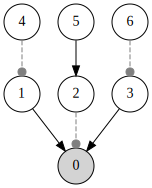

In [59]:
timeserie = load_data("continuous")

test_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, 
               value_children=0)
    .add_nodes(precision=1e1, tonic_volatility=-14.0, volatility_children=0)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, 
               value_children=0)
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
    .add_nodes(precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, 
             value_children=2)
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=3)
).create_belief_propagation_fn()

attributes, edges, update_sequence = (
    test_hgf.get_network()
)

test_hgf.plot_network()

Run functions, plot trajectories and changes

In [ ]:
snapshot_interval = int((len(input_data))/3)
snapshot_counter = snapshot_interval # Ensure initial hgf is in snapshot_list
snapshot_list = []

# for each observation
for value in input_data:

    # interleave observations and masks
    data = (value, 1.0, 1.0)

    # update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=data,
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=test_hgf.input_idxs
    )

    #Calculate gaussian surprise
    index_vec = []
    nr = 0
    for node in edges:
        index_vec.append(nr)
        nr = nr+1

    #Update Attributes and Edges
    for idx in index_vec:
        attributes, edges = update_structure(attributes = attributes, edges = edges, index = idx)

    #If snapshot-counter reached interval, store Attributes, Edges
    if (snapshot_counter == snapshot_interval):
        snap_tuple = (attributes, edges)
        snapshot_list.append(snap_tuple)
        snapshot_counter = 0
    
    snapshot_counter = snapshot_counter+1

new node added
new node added


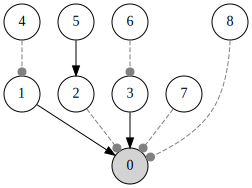

In [63]:
test_hgf.attributes = attributes
test_hgf.edges = edges

test_hgf.plot_network()

Plot attempts

<function matplotlib.pyplot.show(close=None, block=None)>

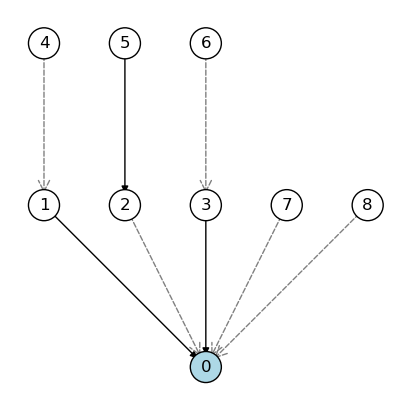

In [64]:
fig = plot_network_x(test_hgf)
plt.show

C:\Users\hesse\AppData\Local\Temp\ipykernel_43220\1221509650.py:127: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


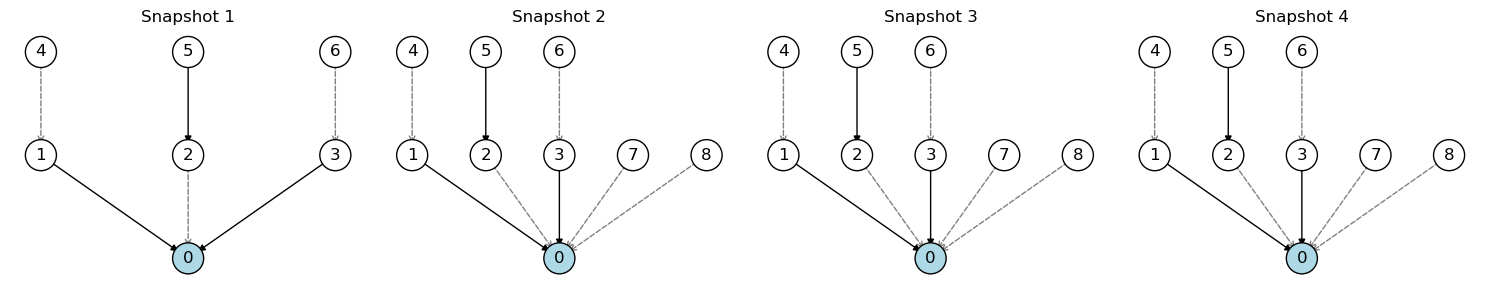

In [65]:
fig = plot_hgf_evolution(test_hgf, snapshot_list, n_cols=4, figsize=(15, 3))

# Display the plot
plt.show()

# Optionally save the figure
# fig.savefig('hgf_evolution.png', dpi=300, bbox_inches='tight')